# BackgroundConvolution.h
It is a convolution taking into acount the variance, so the variance map acts somehow as a filter.
The problem is that it also affects the weights of the different pixels: normalization of the kernel.

I am not entirely sure how it works, let's try to make it visual.

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from astropy.io import fits
import scipy.ndimage as ndimage

In [3]:
def convolve(image, kernel):
    return ndimage.convolve(image, kernel, mode='constant')
    if 0:
        kwidth = kernel.shape[0]
        kheight = kernel.shape[1]
        kxcenter = kwidth // 2
        kycenter = kheight // 2
        convolved = np.zeros(image.shape)

        for x in range(image.shape[0]):
            for y in range(image.shape[1]):
                for kx in range(-(kwidth//2), kwidth//2+1):
                    for ky in range(-(kheight//2), kheight//2+1):
                        x2 = x + kx
                        y2 = y + ky
                        if x2 >= 0 and x2 < image.shape[0] and y2 >= 0 and y2 < image.shape[1]:
                            convolved[x,y] += image[x+kx,y+ky] * kernel[kxcenter+kx,kycenter+ky]
        return convolved

In [4]:
# Existing implementation    
def generateTile(kernel, image, variance, threshold=.5):
    output = np.zeros(image.shape)
    hx = kernel.shape[0] // 2
    hy = kernel.shape[1] // 2
    width = image.shape[0]
    height = image.shape[1]

    for iy in range(0, height):
        for ix in range(0, width):
            total = 0.
            total_ignoring_threshold = 0.
            conv_weight = 0.
            conv_weight_ignoring_threshold = 0.
            if variance[ix, iy] < threshold:
                for cy in range(0, kernel.shape[1]):
                    for cx in range(0, kernel.shape[0]):
                        x2 = ix + cx - hx
                        y2 = iy + cy - hy

                        if x2 >= 0 and x2 < width and y2 >= 0 and y2 < height:
                            if variance[x2,y2] < threshold:
                                total += image[x2, y2] * kernel[cx, cy]
                                conv_weight += kernel[cx, cy]
                            total_ignoring_threshold += image[x2, y2] * kernel[cx, cy]
                            conv_weight_ignoring_threshold += kernel[cx, cy]

                if conv_weight > 0:
                    output[ix, iy] = total / conv_weight
                else:
                    output[ix, iy] = total_ignoring_threshold / conv_weight_ignoring_threshold

    return output

In [5]:
img = np.arange(25).reshape(5,-1).astype(np.float)
var = np.ones((5,5)).astype(np.float)
kernel=np.array([[0,1,0],[1,1,1],[0,1,0]]).astype(np.float)
threshold = 0.5

In [6]:
kernel

array([[0., 1., 0.],
       [1., 1., 1.],
       [0., 1., 0.]])

In [7]:
img

array([[ 0.,  1.,  2.,  3.,  4.],
       [ 5.,  6.,  7.,  8.,  9.],
       [10., 11., 12., 13., 14.],
       [15., 16., 17., 18., 19.],
       [20., 21., 22., 23., 24.]])

In [8]:
var

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [9]:
var[2,2]=0.
var[2,3]=0.
var

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 0., 0., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [10]:
old = generateTile(kernel, img, var, threshold)
old

array([[ 0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. , 12.5, 12.5,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ]])

In [42]:
# Alternative
def generateTileAlt(kernel, image, variance, threshold=5.):
    masked_img = image.copy()
    masked_img[variance > threshold] = 0.
    mask = (variance <= threshold).astype(np.float)
    
    #conv_img = convolve(image, kernel)
    conv_masked_img = convolve(masked_img, kernel)
    conv_var_mask = convolve(mask, kernel)
    #conv_var_neg_mask = convolve((variance > threshold).astype(np.float), kernel)
        
    out = np.zeros(image.shape)
    #out[conv_var_neg_mask > 0] = conv_img[conv_var_neg_mask > 0] / conv_var_neg_mask[conv_var_neg_mask > 0]
    out[mask > 0] = conv_masked_img[mask > 0] / conv_var_mask[mask > 0]
    
    return out

In [43]:
new = generateTileAlt(kernel, img, var, threshold)
new

array([[ 0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. , 12.5, 12.5,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ]])

In [44]:
%timeit old=generateTile(kernel, img, var, threshold)

24.7 µs ± 650 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [45]:
%timeit new=generateTileAlt(kernel, img, var, threshold)

29.5 µs ± 3.12 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [46]:
np.testing.assert_equal(old, new)

## Compare

In [47]:
time_legacy = []
time_new = []

imgsize = 128
for ksize in range(3, 15, 2):
    kernel = np.random.rand(ksize, ksize)
    image = np.random.rand(imgsize, imgsize)
    variance = np.random.rand(imgsize, imgsize)
    
    print(kernel.shape)
    print(image.shape)
    print(variance.shape)
    
    told = %timeit -o old = generateTile(kernel, image, variance, 0.5)
    tnew = %timeit -o new = generateTileAlt(kernel, image, variance, 0.5)
    np.testing.assert_equal(old, new)
    time_legacy.append(told)
    time_new.append(tnew)

(3, 3)
(128, 128)
(128, 128)
91.4 ms ± 1.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
693 µs ± 12.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
(5, 5)
(128, 128)
(128, 128)
212 ms ± 6.55 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.16 ms ± 34.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
(7, 7)
(128, 128)
(128, 128)
441 ms ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.02 ms ± 62.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
(9, 9)
(128, 128)
(128, 128)
652 ms ± 16.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.2 ms ± 148 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
(11, 11)
(128, 128)
(128, 128)
965 ms ± 28.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.56 ms ± 166 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
(13, 13)
(128, 128)
(128, 128)
1.39 s ± 52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.66 ms ± 228 µs per loop (mean ± std. dev. of 7 runs,

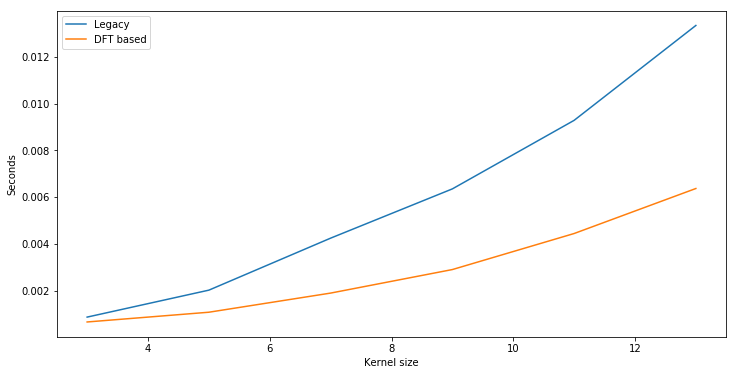

In [48]:
plt.figure(figsize=(12,6))
plt.plot(range(3,15,2), [t.best/100. for t in time_legacy], label='Legacy')
plt.plot(range(3,15,2), [t.best for t in time_new], label='DFT based')
plt.xlabel('Kernel size')
plt.ylabel('Seconds')
plt.legend()

In [49]:
k=np.array([[0,0.5,0],[0.5,1,0.5],[0,0.5,0]])
print(k)
mask=np.array([[0,0,0,0,0],[0,0,0,0,0],[0,0,1,1,0],[0,0,0,0,0],[0,0,0,0,0]]).astype(np.float)
mask_neg=1-mask
img=np.array([[1.0, 2.0, 3.0, 4.0, 5.0],[1.1, 2.1, 3.1, 4.1, 5.1],[1.2, 2.2, 3.2, 4.2, 5.2],[1.3, 2.3, 3.3, 4.3, 5.3],[1.4, 2.4, 3.4, 4.4, 5.4]])
print(mask)
print(img)
print(img*mask)
print(convolve(mask, k))
print(convolve(mask_neg,k))

[[0.  0.5 0. ]
 [0.5 1.  0.5]
 [0.  0.5 0. ]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[1.  2.  3.  4.  5. ]
 [1.1 2.1 3.1 4.1 5.1]
 [1.2 2.2 3.2 4.2 5.2]
 [1.3 2.3 3.3 4.3 5.3]
 [1.4 2.4 3.4 4.4 5.4]]
[[0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  3.2 4.2 0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]]
[[0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0. ]
 [0.  0.5 1.5 1.5 0.5]
 [0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0. ]]
[[2.  2.5 2.5 2.5 2. ]
 [2.5 3.  2.5 2.5 2.5]
 [2.5 2.5 1.5 1.5 2. ]
 [2.5 3.  2.5 2.5 2.5]
 [2.  2.5 2.5 2.5 2. ]]
